# Orbit integration, comparison with other dwarf galaxies

Import necessary packages

In [6]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None #overwriting values in df without warnings
pd.set_option('display.max_columns', None) #display whole table in line
pd.set_option('display.max_rows', None)

from astropy import units as u
from astropy.coordinates import SkyCoord

import galpy
from galpy.util import conversion
from galpy.orbit import Orbit
from galpy.potential import ChandrasekharDynamicalFrictionForce
from galpy.potential import HernquistPotential, MovingObjectPotential, NonInertialFrameForce
from galpy.potential import (evaluateRforces, evaluatephitorques, evaluatezforces)

import scipy
import properties_utils as pu

In [2]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

In [3]:
# open dwarf galaxy data
mw_dwarfs = pd.read_csv("data/evaluated_mwdg.csv")
w1 = mw_dwarfs[mw_dwarfs["key"] == "willman_1"] # drop W1 from MW dwarfs

w1_mv_app = w1["apparent_magnitude_v"].values[0]
w1_mv_app_err = w1["apparent_magnitude_v_ep"].values[0]
pu.save_variable("MV_app", [w1_mv_app, w1_mv_app_err])

w1_index = w1.index[0]
mw_dwarfs = mw_dwarfs.drop([w1_index])

# open globular cluster data
mw_clusters = pd.read_csv("data/evaluated_mwgc.csv")

# open ambiguous object data
ambiguous = pd.read_csv("data/gc_ambiguous.csv")

### Orbit integration

In [7]:
from galpy.potential import MWPotential2014
# MWPotential2014[2] *= 1.5 # halo 50% bigger

o_lmc = Orbit.from_name('LMC')
lmc_mass = 1.38 * 10.**11 * u.Msun # total mass
lmc_rhalf = 8.7 * u.kpc # r_half
cdf_lmc = ChandrasekharDynamicalFrictionForce(GMs = lmc_mass, rhm = lmc_rhalf, dens = MWPotential2014)

time_step_lmc = np.linspace(0., -10., 1001)*u.Gyr
o_lmc.integrate(time_step_lmc, MWPotential2014 + cdf_lmc, method = 'dop853_c')

# model LMC potential
lmcpot = HernquistPotential(amp = 2 * lmc_mass, a = lmc_rhalf/(1. + np.sqrt(2.))) #rhm = (1+sqrt(2)) a
moving_lmcpot = MovingObjectPotential(o_lmc, pot = lmcpot)

# calculate acceleration due to LMC at the origin
loc_origin = 1e-4 # Small offset in R to avoid numerical issues
ax = lambda t: evaluateRforces(moving_lmcpot, loc_origin, 0., phi = 0., t = t, use_physical = False)
ay = lambda t: evaluatephitorques(moving_lmcpot, loc_origin, 0., phi = 0., t = t, use_physical = False) / loc_origin
az = lambda t: evaluatezforces(moving_lmcpot, loc_origin, 0., phi = 0., t = t, use_physical = False)

# interpolate
if o_lmc.time(use_physical = False)[0] > o_lmc.time(use_physical = False)[1]:
    t_intunits = o_lmc.time(use_physical = False)[::-1] # need to reverse the order for interp
else:
    t_intunits = o_lmc.time(use_physical = False)

ax4int = np.array([ax(t) for t in t_intunits])
ax_int = lambda t: np.interp(t, t_intunits, ax4int)

ay4int = np.array([ay(t) for t in t_intunits])
ay_int = lambda t: np.interp(t, t_intunits, ay4int)

az4int = np.array([az(t) for t in t_intunits])
az_int = lambda t: np.interp(t, t_intunits, az4int)

# set up non-inertial reference frame
nip = NonInertialFrameForce(a0 = [ax_int, ay_int, az_int])

In [8]:
def orbit(obj_name, obj_ra, obj_dec, obj_dist, obj_dist_err, obj_pmra, obj_pmra_err, obj_pmdec, obj_pmdec_err, obj_vel, obj_vel_err):
    # create samples
    num = 1000

    ras = np.full((num), obj_ra)
    decs = np.full((num), obj_dec)
    dists = scipy.stats.norm.rvs(loc = obj_dist, scale = obj_dist_err, size = num) #normal dist
    pmras = scipy.stats.norm.rvs(loc = obj_pmra, scale = obj_pmra_err, size = num) #normal dist
    pmdecs = scipy.stats.norm.rvs(loc = obj_pmdec, scale = obj_pmdec_err, size = num) #normal dist
    vels = scipy.stats.norm.rvs(loc = obj_vel, scale = obj_vel_err, size = num) #normal dist

    # create coordinates
    samp_coords = SkyCoord(ra = ras * u.degree, dec = decs * u.degree, distance = dists * u.kpc,
                      pm_ra_cosdec = pmras * u.mas/u.yr, pm_dec = pmdecs * u.mas/u.yr, radial_velocity = vels * u.km/u.s)
    coords = SkyCoord(ra = obj_ra * u.degree, dec = obj_dec * u.degree, distance = obj_dist * u.kpc,
                      pm_ra_cosdec = obj_pmra * u.mas/u.yr, pm_dec = obj_pmdec * u.mas/u.yr, radial_velocity = obj_vel * u.km/u.s)
    
    # calculate orbit
    obj_orbit = Orbit(coords)
    orbit_samps = Orbit(samp_coords)
    
    # define time step
    t_step = np.linspace(0, -10, 1001) * u.Gyr
    t_step2 = np.linspace(0, -1, 101) * u.Gyr

    # integrate orbit
    obj_orbit.integrate(t_step, MWPotential2014 + nip + moving_lmcpot)
    orbit_samps.integrate(t_step2, MWPotential2014 + nip + moving_lmcpot)
    
    # orbital parameters
    pericenter, apocenter, eccentricity = obj_orbit.rperi(), obj_orbit.rap(), obj_orbit.e()
    fperi_obj = (obj_orbit.r() - obj_orbit.rperi()) / (obj_orbit.rap() - obj_orbit.rperi())
    Lz, E = (-obj_orbit.Lz()  * (u.km / u.s) * u.kpc).to(u.kpc**2 / u.Myr), (obj_orbit.E() * (u.km/u.s)**2).to(u.kpc**2 / u.Myr **2)
    radius_data = obj_orbit.r(t_step)
    
    pericenters, apocenters, eccentricities, radius = orbit_samps.rperi(), orbit_samps.rap(), orbit_samps.e(), orbit_samps.r()
    
    peri16, peri50, peri84 = np.percentile(pericenters, 16), np.percentile(pericenters, 50), np.percentile(pericenters, 84)
    apo16, apo50, apo84 = np.percentile(apocenters, 16), np.percentile(apocenters, 50), np.percentile(apocenters, 84)
    ecc16, ecc50, ecc84 = np.percentile(eccentricities, 16), np.percentile(eccentricities, 50), np.percentile(eccentricities, 84)
    
    fperi = (orbit_samps.r() - orbit_samps.rperi()) / (orbit_samps.rap() - orbit_samps.rperi())
    Lz_samp = (- orbit_samps.Lz() * (u.km / u.s) * u.kpc).to(u.kpc**2 / u.Myr)
    E_samp = (orbit_samps.E() * (u.km/u.s)**2).to(u.kpc**2 / u.Myr **2)

    fperi16, fperi50, fperi84 = np.percentile(fperi, 16), np.percentile(fperi, 50), np.percentile(fperi, 84)
    Lz16, Lz50, Lz84 = np.percentile(Lz_samp.value, 16), np.percentile(Lz_samp.value, 50), np.percentile(Lz_samp.value, 84)
    E16, E50, E84 = np.percentile(E_samp.value, 16), np.percentile(E_samp.value, 50), np.percentile(E_samp.value, 84)
    
    return_list = [pericenter, peri16, peri50, peri84,
                   apocenter, apo16, apo50, apo84, 
                   eccentricity, ecc16, ecc50, ecc84,
                   fperi_obj, fperi16, fperi50, fperi84, 
                   Lz.value, Lz16, Lz50, Lz84, 
                   E.value, E16, E50, E84]
        
    return return_list

### Willman 1

In [9]:
from wil1_properties import ra_w1, dec_w1, dist, dist_err, pmra_w1, pmdec_w1, vsys, dm_wil1, dm_wil1_err, feh_w1, r_half_pc, r_half_pc_err, vdisp

In [10]:
wil1_params = orbit("W1", ra_w1, dec_w1, dist, dist_err, pmra_w1[0], pmra_w1[1], pmdec_w1[0], pmdec_w1[1], vsys[0], vsys[1])

In [11]:
wil1_peri, wil1_peri16, wil1_peri50, wil1_peri84     = wil1_params[0], wil1_params[1], wil1_params[2], wil1_params[3]
wil1_apo, wil1_apo16, wil1_apo50, wil1_apo84         = wil1_params[4], wil1_params[5], wil1_params[6], wil1_params[7]
wil1_ecc, wil1_ecc16, wil1_ecc50, wil1_ecc84         = wil1_params[8], wil1_params[9], wil1_params[10], wil1_params[11]
wil1_fperi, wil1_fperi16, wil1_fperi50, wil1_fperi84 = wil1_params[12], wil1_params[13], wil1_params[14], wil1_params[15]
wil1_Lz, wil1_Lz16, wil1_Lz50, wil1_Lz84             = wil1_params[16], wil1_params[17], wil1_params[18], wil1_params[19]
wil1_E, wil1_E16, wil1_E50, wil1_E84                 = wil1_params[20], wil1_params[21], wil1_params[22], wil1_params[23]

In [12]:
print("Pericenter [kpc]: {:.1f} + {:.1f} - {:.1f}".format(wil1_peri50, wil1_peri84 - wil1_peri50, wil1_peri50 - wil1_peri16))
print("Apocenter [kpc]:  {:.1f} + {:.1f} - {:.1f}".format(wil1_apo50, wil1_apo84 - wil1_apo50, wil1_apo50 - wil1_apo16))
print("Eccentricity:     {:.2f} + {:.2f} - {:.2f}".format(wil1_ecc50, wil1_ecc84 - wil1_ecc50, wil1_ecc50 - wil1_ecc16))

Pericenter [kpc]: 14.7 + 1.9 - 1.6
Apocenter [kpc]:  43.2 + 0.4 - 0.4
Eccentricity:     0.49 + 0.04 - 0.05


# Figure 11: Comparison 1

In [13]:
# dwarf galaxies
dwarfs_feh = mw_dwarfs["metallicity_spectroscopic"].values
dwarfs_feh_err = np.array([mw_dwarfs["metallicity_spectroscopic_ep"].values, mw_dwarfs["metallicity_spectroscopic_em"].values])

dwarfs_rhalf = mw_dwarfs["rhalf"].values
dwarfs_rhalf_err = (mw_dwarfs["rhalf_ep"].values + mw_dwarfs["rhalf_em"].values) / 2
dwarfs_dist = mw_dwarfs["distance"].values
dwarfs_dist_err = (mw_dwarfs["distance_ep"].values + mw_dwarfs["distance_em"].values) / 2
dwarfs_rhalf_pc, dwarfs_rhalf_pc_err = pu.calc_rhalf_pc(dwarfs_rhalf, dwarfs_rhalf_err, dwarfs_dist, dwarfs_dist_err)

dwarfs_mv = mw_dwarfs["M_V"].values
dwarfs_mv_err = (mw_dwarfs["M_V_em"].values + mw_dwarfs["M_V_ep"].values) / 2

# globular clusters
gc_feh = mw_clusters["metallicity"].values
gc_feh_err = (mw_clusters["metallicity_ep"].values + mw_clusters["metallicity_em"].values) / 2

gc_rhalf = mw_clusters["rhalf"].values
gc_rhalf_err = (mw_clusters["rhalf_ep"].values + mw_clusters["rhalf_em"].values) / 2
gc_dist = mw_clusters["distance"].values
gc_dist_err = (mw_clusters["distance_ep"].values + mw_clusters["distance_em"].values) / 2
gc_rhalf_pc, gc_rhalf_pc_err = pu.calc_rhalf_pc(gc_rhalf, gc_rhalf_err, gc_dist, gc_dist_err)

gc_mv = mw_clusters["M_V"].values
gc_mv_err = np.array([mw_clusters["M_V_ep"].values, mw_clusters["M_V_em"].values])

# ambiguous
ambiguous_feh = ambiguous["metallicity"].values
ambiguous_feh_err = np.array([ambiguous["metallicity_ep"].values, ambiguous["metallicity_em"].values])

ambiguous_rhalf = ambiguous["rhalf"].values
ambiguous_rhalf_err = (ambiguous["rhalf_ep"].values + ambiguous["rhalf_em"].values) / 2
ambiguous_dist = ambiguous["distance"].values
ambiguous_dist_err = (ambiguous["distance_ep"].values + ambiguous["distance_em"].values) / 2
ambiguous_rhalf_pc, ambiguous_rhalf_pc_err = pu.calc_rhalf_pc(ambiguous_rhalf, ambiguous_rhalf_err, ambiguous_dist, ambiguous_dist_err)

ambiguous_mv = ambiguous["M_V"].values
ambiguous_mv_err = (ambiguous["M_V_ep"].values + ambiguous["M_V_em"].values) / 2

# willman 1
w1_mv = w1_mv_app - dm_wil1
w1_mv_err = (w1_mv_app_err ** 2 + dm_wil1_err ** 2) ** (0.5)

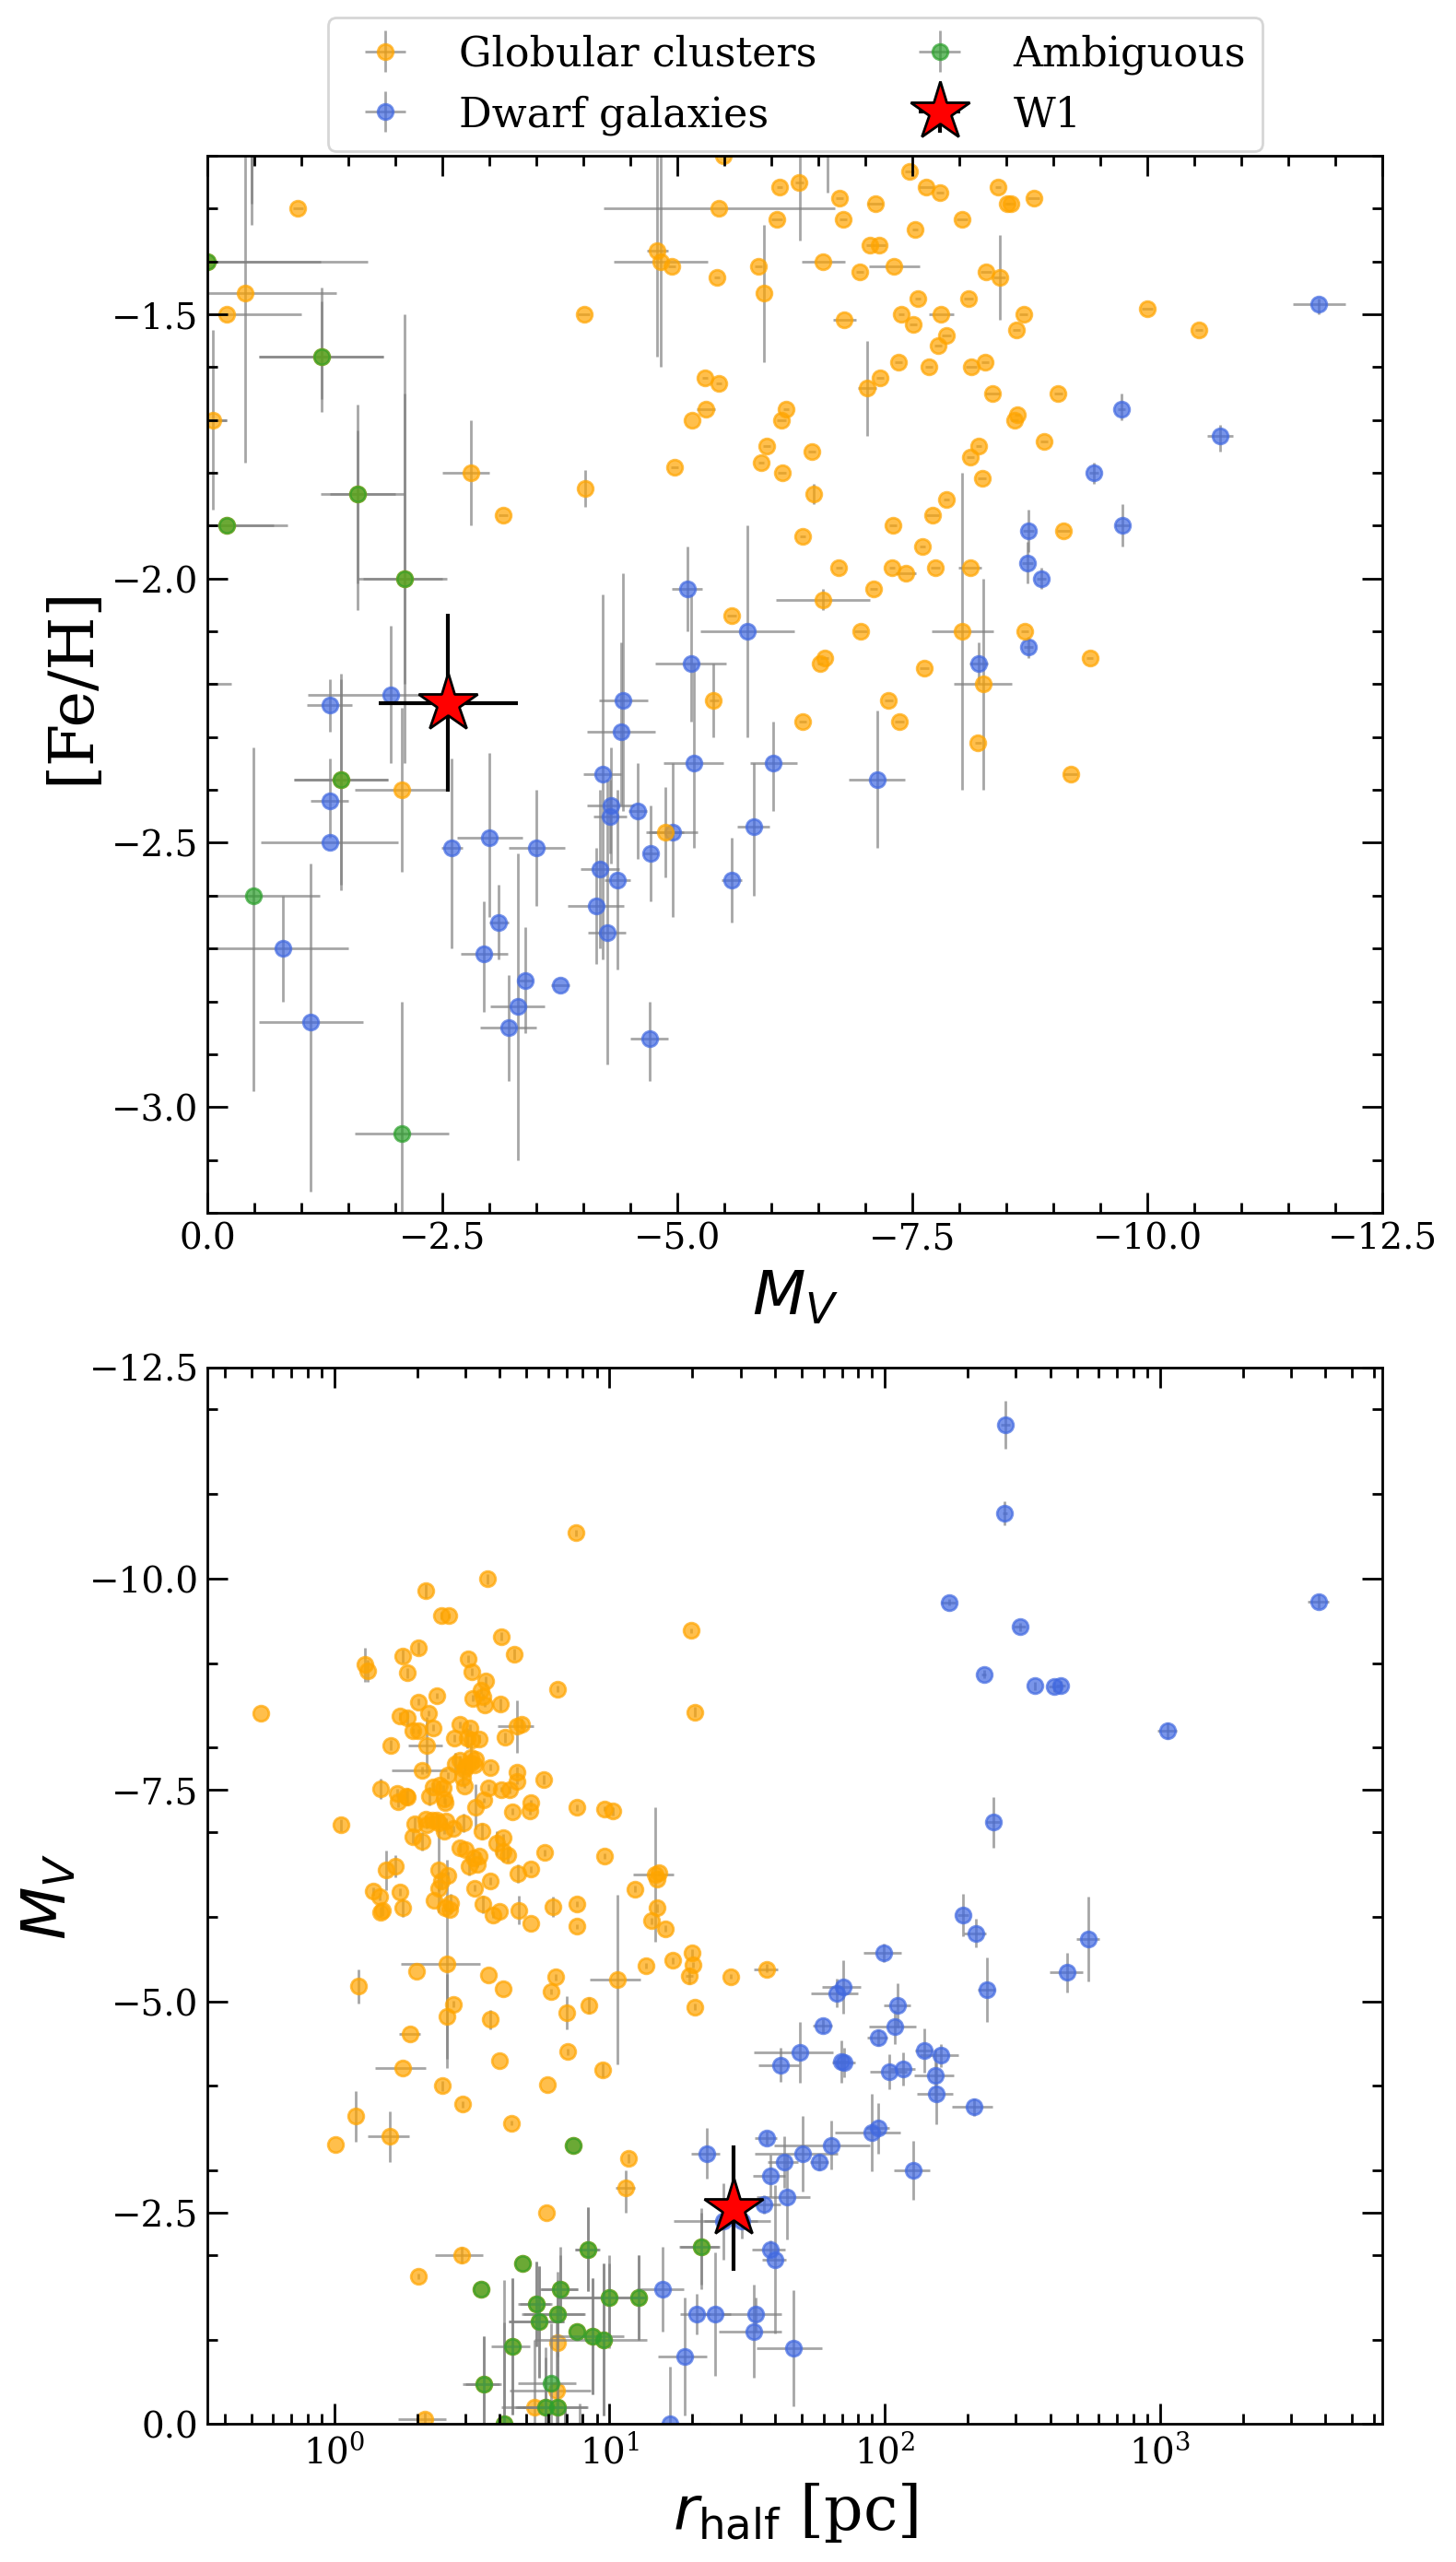

In [14]:
fig, axes = plt.subplots(2, 1, figsize = (8, 14), tight_layout = True)

### Fe/H, M_V ###
axes[0].errorbar(dwarfs_mv, dwarfs_feh, yerr = dwarfs_feh_err, xerr = dwarfs_mv_err, 
                 elinewidth = 1, ecolor = "grey", c = "royalblue", fmt = "o", ms = 6, alpha = 0.7, zorder = 0, rasterized = True)
axes[0].errorbar(gc_mv, gc_feh, yerr = gc_feh_err, xerr = gc_mv_err, 
                 elinewidth = 1, ecolor = "grey", c = "orange", fmt = "o", ms = 6, alpha = 0.7, zorder = 0, rasterized = True)
axes[0].errorbar(ambiguous_mv, ambiguous_feh, yerr = ambiguous_feh_err, xerr = ambiguous_mv_err, 
                 elinewidth = 1, ecolor = "grey", c = "tab:green", fmt = "o", ms = 6, alpha = 0.7, zorder = 0, rasterized = True)

axes[0].errorbar(w1_mv, feh_w1[0], yerr = feh_w1[1], xerr = w1_mv_err, 
                 ecolor = "black", c = "red", mec = "black", fmt='*', ms = 24, zorder = 1)

axes[0].set_xlabel(r'$M_V$', size = 24)
axes[0].set_ylabel('[Fe/H]', size = 24)

axes[0].set_xticks(np.arange(-15, 5, 2.5), minor = False)
axes[0].set_xticks(np.arange(-15, 5, 0.5), minor = True)
axes[0].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
axes[0].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[0].set_yticks(np.arange(-3, 1, 0.5), minor = False)
axes[0].set_yticks(np.arange(-3.2, 1, 0.1), minor = True)
axes[0].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
axes[0].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

axes[0].set_xlim(0, -12.5)
axes[0].set_ylim(-3.2, -1.2)

### M_V, rhalf ###
axes[1].errorbar(gc_rhalf_pc, gc_mv, yerr = gc_mv_err, xerr = gc_rhalf_pc_err, 
                 elinewidth = 1, ecolor = "grey", c = "orange", fmt = "o", ms = 6, alpha = 0.7, zorder = 0, label = "Globular clusters", rasterized = True)
axes[1].errorbar(dwarfs_rhalf_pc, dwarfs_mv, yerr = dwarfs_mv_err, xerr = dwarfs_rhalf_pc_err, 
                 elinewidth = 1, ecolor = "grey", c = "royalblue", fmt = "o", ms = 6, alpha = 0.7, zorder = 1, label = "Dwarf galaxies", rasterized = True)
axes[1].errorbar(ambiguous_rhalf_pc, ambiguous_mv, yerr = ambiguous_mv_err, xerr = ambiguous_rhalf_pc_err, 
                 elinewidth = 1, ecolor = "grey", c = "tab:green", fmt = "o", ms = 6, alpha = 0.7, zorder = 1, label = "Ambiguous", rasterized = True)

axes[1].errorbar(r_half_pc, w1_mv, yerr = w1_mv_err, xerr = r_half_pc_err, 
                 ecolor = "black", c = "red", mec = "black", fmt='*', ms = 24, zorder = 2, label = "W1", rasterized = True)

axes[1].set_xscale("log")

axes[1].set_xlabel(r'$r_{\rm half}$ [pc]', size = 24)
axes[1].set_ylabel(r'$M_V$', size = 24)

axes[1].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
axes[1].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[1].set_yticks(np.arange(-20, 5, 2.5), minor = False)
axes[1].set_yticks(np.arange(-18, 1, 1), minor = True)
axes[1].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
axes[1].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

axes[1].set_ylim(0, -12.5)

legend_points, legend_labels = axes[1].get_legend_handles_labels()
axes[0].legend(legend_points, legend_labels, loc = 'upper center', fontsize = 16, bbox_to_anchor = (0.5, 1.15), ncol = 2, fancybox = True)

fig.savefig("plots/9_comparison1.pdf", dpi = 600, transparent = True)

## Figure 12: Comparison 2

In [15]:
def calc_eminor(e, a):
    """calculate semi-minor axis from eccentricity (e) and semi major axis (a)"""
    return np.sqrt((a ** 2) * (1 - e ** 2))

def calc_fminor(f, a):
    """calculate semi-minor axis from ellipticity (f) and semi major axis (a)"""
    return a * (1-f)

In [16]:
# apocenter, pericenter data
wil1_peri_err = np.array([[wil1_peri84 - wil1_peri50, wil1_peri50 - wil1_peri16]]).T
wil1_apo_err  = np.array([[wil1_apo84 - wil1_apo50, wil1_apo50 - wil1_apo16]]).T

gc_peri_err = np.array([mw_clusters["peri84"] - mw_clusters["peri50"], mw_clusters["peri50"] - mw_clusters["peri16"]])
gc_apo_err  = np.array([mw_clusters["apo84"] - mw_clusters["apo50"], mw_clusters["apo50"] - mw_clusters["apo16"]])

dg_peri_err = np.array([mw_dwarfs["peri84"] - mw_dwarfs["peri50"], mw_dwarfs["peri50"] - mw_dwarfs["peri16"]])
dg_apo_err  = np.array([mw_dwarfs["apo84"] - mw_dwarfs["apo50"], mw_dwarfs["apo50"] - mw_dwarfs["apo16"]])

ecc_yvals   = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])

# fperi data
wil1_fperi_err = np.array([[wil1_fperi84 - wil1_fperi50, wil1_fperi50 - wil1_fperi16]]).T
gc_fperi_err   = np.array([mw_clusters["fperi84"] - mw_clusters["fperi50"], mw_clusters["fperi50"] - mw_clusters["fperi16"]])
dg_fperi_err   = np.array([mw_dwarfs["fperi84"] - mw_dwarfs["fperi50"], mw_dwarfs["fperi50"] - mw_dwarfs["fperi16"]])

# eccentricity data
wil1_ecc_err = np.array([[wil1_ecc84 - wil1_ecc50, wil1_ecc50 - wil1_ecc16]]).T
gc_ecc_err   = np.array([mw_clusters["ecc84"] - mw_clusters["ecc50"], mw_clusters["ecc50"] - mw_clusters["ecc16"]])
dg_ecc_err   = np.array([mw_dwarfs["ecc84"] - mw_dwarfs["ecc50"], mw_dwarfs["ecc50"] - mw_dwarfs["ecc16"]])

# energy, momentum data
wil1_Lz_err = np.array([[wil1_Lz84 - wil1_Lz50, wil1_Lz50 - wil1_Lz16]]).T
wil1_E_err  = np.array([[wil1_E84 - wil1_E50, wil1_E50 - wil1_E16]]).T

gc_Lz_err = np.array([mw_clusters["Lz84"] - mw_clusters["Lz50"], mw_clusters["Lz50"] - mw_clusters["Lz16"]])
gc_E_err  = np.array([mw_clusters["E84"] - mw_clusters["E50"], mw_clusters["E50"] - mw_clusters["E16"]])

dg_Lz_err = np.array([mw_dwarfs["Lz84"] - mw_dwarfs["Lz50"], mw_dwarfs["Lz50"] - mw_dwarfs["Lz16"]])
dg_E_err  = np.array([mw_dwarfs["E84"] - mw_dwarfs["E50"], mw_dwarfs["E50"] - mw_dwarfs["E16"]])

# radial velocity
dg_rv = mw_dwarfs["vlos_systemic"]
dg_rv_err = np.array([mw_dwarfs["vlos_systemic_ep"].values, mw_dwarfs["vlos_systemic_em"].values])

gc_rv = mw_clusters["vlos_systemic"]
gc_rv_err = np.array([mw_clusters["vlos_systemic_ep"].values, mw_clusters["vlos_systemic_em"].values])

from wil1_properties import vsys
w1_rv, w1_rv_err = vsys

# galactocentric radius
from astropy import coordinates as coord

def get_galactocentric_dist(ra, dec, dist, dist_err, num = 1000):
    if dist_err > 0:
        dists = scipy.stats.norm.rvs(loc = dist, scale = dist_err, size = num)
        coords = SkyCoord(ra = ra * u.degree, dec = dec * u.degree, distance = dists * u.kpc)
        gc_frame = coord.Galactocentric()
        galactocentric_coord = coords.transform_to(gc_frame)
        dist_g = np.sqrt(galactocentric_coord.x**2 + galactocentric_coord.y**2 + galactocentric_coord.z**2)

        return np.median(dist_g.value), np.median(dist_g.value) - np.percentile(dist_g.value, 16), np.percentile(dist_g.value, 84) - np.median(dist_g.value)
    else:
        coords = SkyCoord(ra = ra * u.degree, dec = dec * u.degree, distance = dist * u.kpc)
        gc_frame = coord.Galactocentric()
        galactocentric_coord = coords.transform_to(gc_frame)
        dist_g = np.sqrt(galactocentric_coord.x**2 + galactocentric_coord.y**2 + galactocentric_coord.z**2)

        return dist_g.value, 0, 0

w1_rg, w1_rg_em, w1_rg_ep = get_galactocentric_dist(ra_w1, dec_w1, dist, dist_err)
w1_rg_err = np.array([[w1_rg_ep], [w1_rg_em]])

for index, row in mw_dwarfs.iterrows():
    ra = row["ra"]
    dec = row["dec"]
    dist = row["distance"]
    dist_err = (row["distance_ep"] + row["distance_em"]) / 2

    if dist > 0:
        r_gal, r_gal_em, r_gal_ep = get_galactocentric_dist(ra, dec, dist, dist_err)
        mw_dwarfs.loc[index, "r_galac"] = r_gal
        mw_dwarfs.loc[index, "r_galac_ep"] = r_gal_ep
        mw_dwarfs.loc[index, "r_galac_em"] = r_gal_em

dg_rgal = mw_dwarfs["r_galac"]
dg_rgal_err = np.array([mw_dwarfs["r_galac_ep"], mw_dwarfs["r_galac_ep"]])

for index, row in mw_clusters.iterrows():
    ra = row["ra"]
    dec = row["dec"]
    dist = row["distance"]
    dist_err = (row["distance_ep"] + row["distance_em"]) / 2

    if dist > 0:
        r_gal, r_gal_em, r_gal_ep = get_galactocentric_dist(ra, dec, dist, dist_err)
        mw_clusters.loc[index, "r_galac"] = r_gal
        mw_clusters.loc[index, "r_galac_ep"] = r_gal_ep
        mw_clusters.loc[index, "r_galac_em"] = r_gal_em

gc_rgal = mw_clusters["r_galac"]
gc_rgal_err = np.array([mw_clusters["r_galac_ep"], mw_clusters["r_galac_ep"]])

In [17]:
def calc_dens(mass, mass_err, rh, rh_err):
    density = mass / ((4/3) * m.pi * (rh ** 3))

    density_mass_err = density * mass_err / mass
    density_rh_err = -3 * rh_err * mass / ((4/3) * m.pi * rh ** 4)
    density_err = (density_mass_err ** 2 + density_rh_err ** 2) ** (0.5)
    
    return density, density_err

In [18]:
mw_dwarfs["mass"], mw_dwarfs["mass_err"] = np.nan, np.nan
mw_dwarfs["density"], mw_dwarfs["density_err"] = np.nan, np.nan
mw_dwarfs["rhalf_pc"], mw_dwarfs["rhalf_pc_err"] = np.nan, np.nan

wil1_mass_em, wil1_mass, will_mass_ep = pu.calc_mass(vdisp[0], vdisp[2], vdisp[1], r_half_pc, r_half_pc_err, p = 0)
wil1_mass_err = (will_mass_ep + wil1_mass_em) / 2
wil1_density, wil1_density_err = calc_dens(wil1_mass, wil1_mass_err, r_half_pc / 1e3, r_half_pc_err / 1e3)

for ii, row in mw_dwarfs.iterrows():
    vdisp = row["vlos_sigma"]
    vdisp_ep, vdisp_em = row["vlos_sigma_ep"], row["vlos_sigma_em"]
    rhalf, rhalf_err = row["rhalf"], (row["rhalf_ep"] + row["rhalf_em"]) / 2
    dist, dist_err = row["distance"], (row["distance_ep"] + row["distance_em"]) / 2
    rhalf_pc, rhalf_pc_err = pu.calc_rhalf_pc(rhalf, rhalf_err, dist, dist_err)
    rhalf_kpc, rhalf_kpc_err = rhalf_pc / 10**3, rhalf_pc_err / 10**3

    mw_dwarfs.loc[ii, "rhalf_pc"] = rhalf_pc
    mw_dwarfs.loc[ii, "rhalf_pc_err"] = rhalf_pc_err

    if np.isnan(vdisp) | np.isnan(rhalf):
        mass, mass_err = np.nan, np.nan
        density, density_err = np.nan, np.nan

    else:
        mass_em, mass, mass_ep = pu.calc_mass(vdisp, vdisp_ep, vdisp_em, rhalf_pc, rhalf_pc_err, p = 0)
        mass_err = (mass_ep + mass_em) / 2
        density, density_err = calc_dens(mass, mass_err, rhalf_kpc, rhalf_kpc_err)

    # save to df
    mw_dwarfs.loc[ii, "mass"], mw_dwarfs.loc[ii, "mass_err"] = mass, mass_err
    mw_dwarfs.loc[ii, "density"], mw_dwarfs.loc[ii, "density_err"] = density, density_err

In [19]:
mw_clusters["mass"], mw_clusters["mass_err"] = np.nan, np.nan
mw_clusters["density"], mw_clusters["density_err"] = np.nan, np.nan
mw_clusters["rhalf_pc"], mw_clusters["rhalf_pc_err"] = np.nan, np.nan

for ii, row in mw_clusters.iterrows():
    vdisp = row["vlos_sigma"]
    vdisp_ep, vdisp_em = row["vlos_sigma_ep"], row["vlos_sigma_em"]
    rhalf, rhalf_err = row["rhalf"], (row["rhalf_ep"] + row["rhalf_em"]) / 2
    dist, dist_err = row["distance"], (row["distance_ep"] + row["distance_em"]) / 2
    rhalf_pc, rhalf_pc_err = pu.calc_rhalf_pc(rhalf, rhalf_err, dist, dist_err)
    rhalf_kpc, rhalf_kpc_err = rhalf_pc / 10**3, rhalf_pc_err / 10**3

    mw_clusters.loc[ii, "rhalf_pc"] = rhalf_pc
    mw_clusters.loc[ii, "rhalf_pc_err"] = rhalf_pc_err

    if np.isnan(vdisp) | np.isnan(rhalf):
        mass, mass_err = np.nan, np.nan
        density, density_err = np.nan, np.nan

    else:
        mass_em, mass, mass_ep = pu.calc_mass(vdisp, vdisp_ep, vdisp_em, rhalf_pc, rhalf_pc_err, p = 0)
        mass_err = (mass_ep + mass_em) / 2
        density, density_err = calc_dens(mass, mass_err, rhalf_kpc, rhalf_kpc_err)

    # save to df
    mw_clusters.loc[ii, "mass"], mw_clusters.loc[ii, "mass_err"] = mass, mass_err
    mw_clusters.loc[ii, "density"], mw_clusters.loc[ii, "density_err"] = density, density_err

In [20]:
half, rhalf_err = mw_clusters["rhalf"], (mw_clusters["rhalf_ep"] + mw_clusters["rhalf_em"]) / 2
gc_dist, gc_dist_err = mw_clusters["distance"], (mw_clusters["distance_ep"] + mw_clusters["distance_em"]) / 2
rhalf_pc, rhalf_pc_err = pu.calc_rhalf_pc(rhalf, rhalf_err, gc_dist, gc_dist_err)
rhalf_kpc, rhalf_kpc_err = rhalf_pc / 10**3, rhalf_pc_err / 10**3
mass = 10 ** mw_clusters["mass_stellar"]

mw_clusters["density"], mw_clusters["density_err"] = calc_dens(mass, 0, rhalf_kpc, rhalf_kpc_err)

In [21]:
radius = np.arange(0.02, 10**3, 1)
density_mw = np.array([])

for i in range(len(radius)):
    mw_mass = galpy.potential.mass(MWPotential2014, R = radius[i] * u.kpc) * conversion.mass_in_msol(220.,8.)
    mw_density = mw_mass / ((4/3) * m.pi * radius[i] ** 3)
    density_mw = np.append(density_mw, mw_density * 2)

In [22]:
# escape velocity
r = np.linspace(0, 400, 1000) * u.kpc
vesc = galpy.potential.vesc(MWPotential2014, r) * 220

/Users/camillechiu/opt/anaconda3/envs/astrowillman1/lib/python3.12/site-packages/galpy/potential/PowerSphericalPotentialwCutoff.py:85: RuntimeWarning: invalid value encountered in divide
  - special.gamma(1.5 - self.alpha / 2.0)

/Users/camillechiu/opt/anaconda3/envs/astrowillman1/lib/python3.12/site-packages/galpy/potential/TwoPowerSphericalPotential.py:883: RuntimeWarning: divide by zero encountered in divide
  out = -special.xlogy(1.0 / r, 1.0 + r / self.a)  # stable as r -> infty



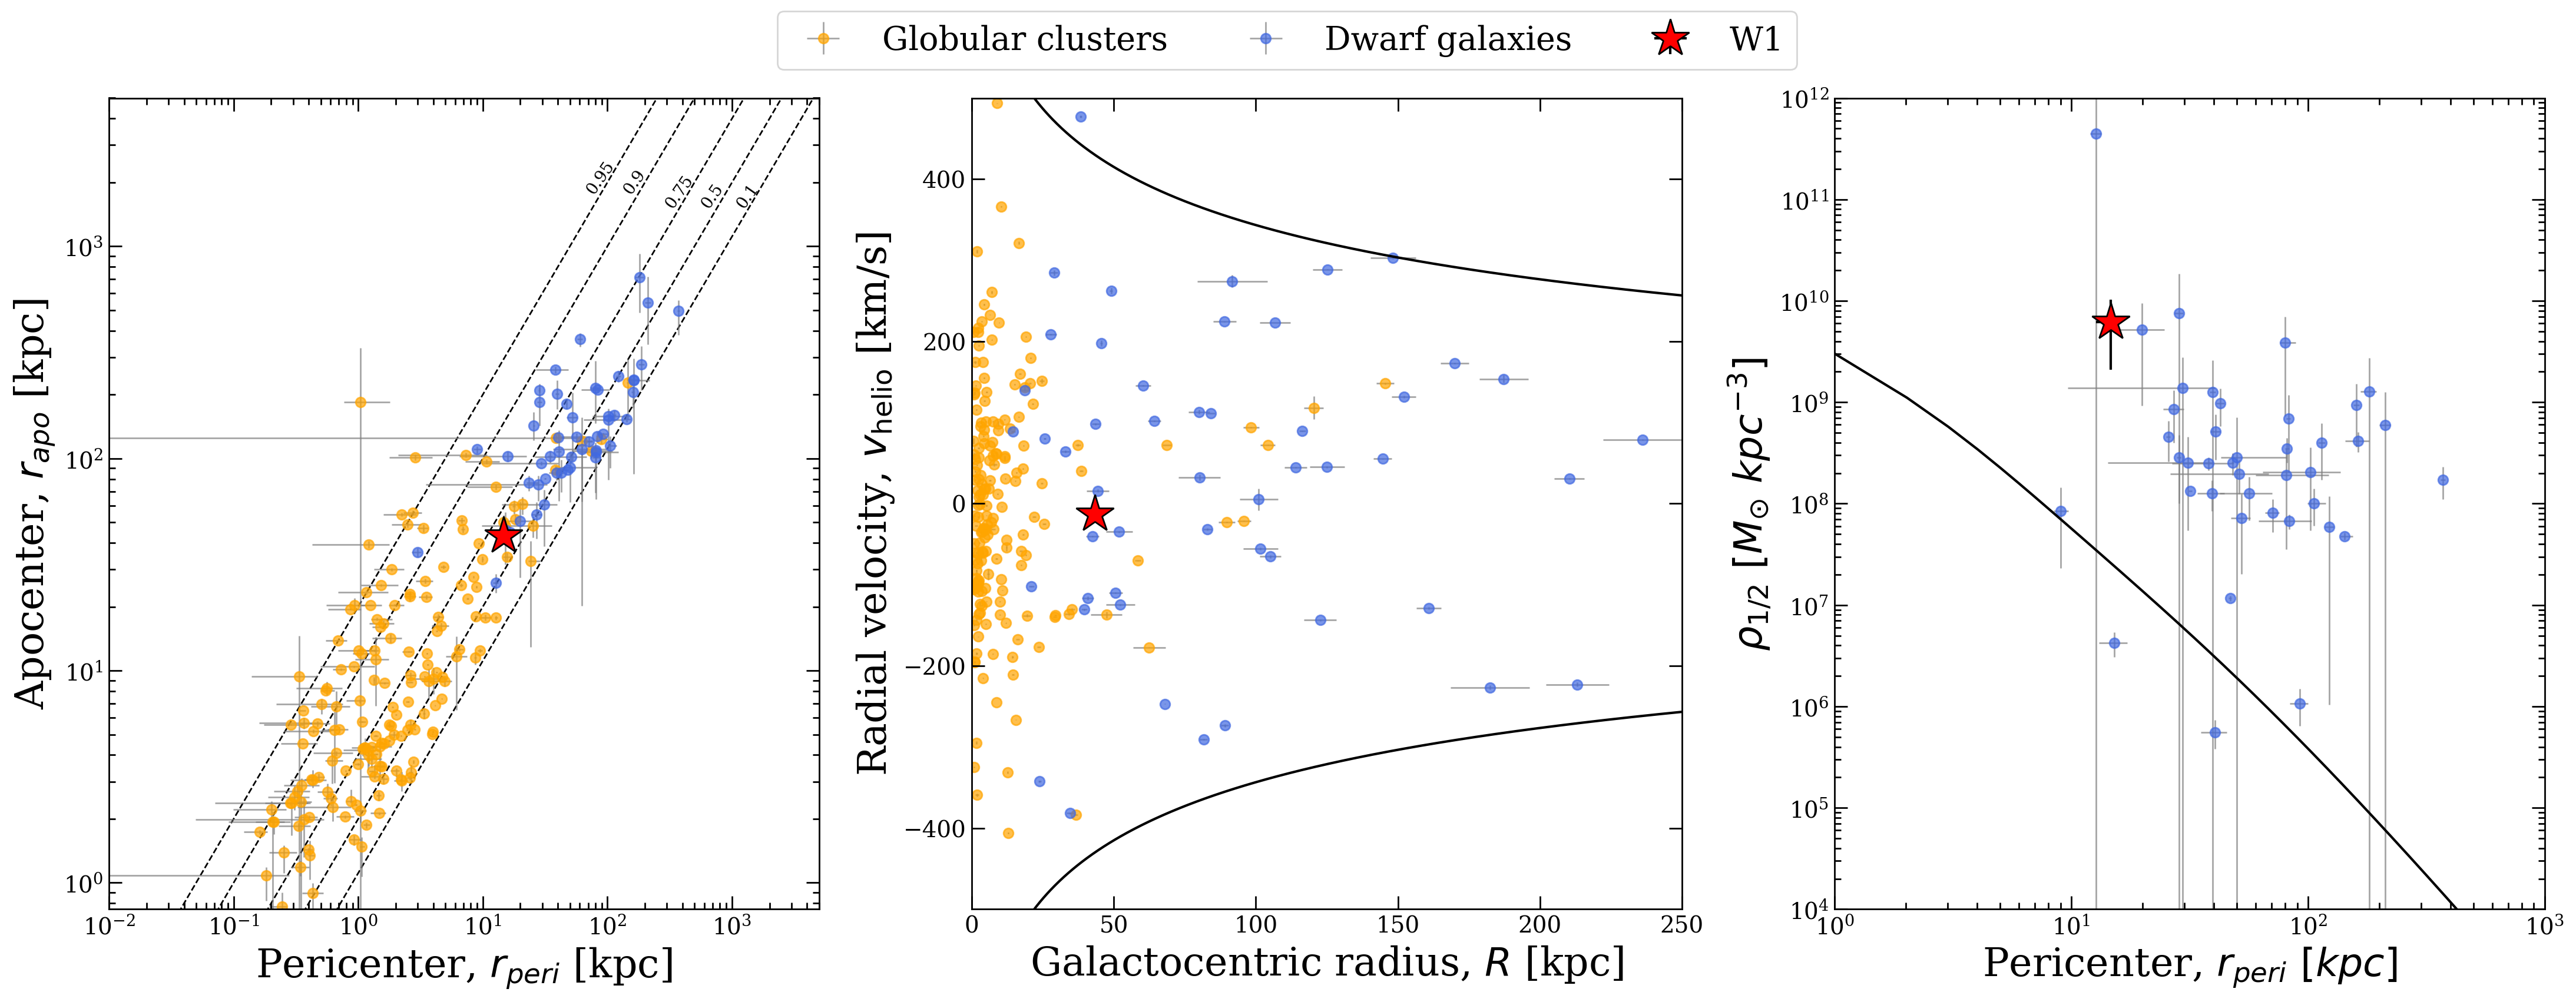

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (22, 8), tight_layout = True)

#### apo/peri comparison
ax[0].plot(calc_fminor(0.95, ecc_yvals), ecc_yvals, linestyle = "--", linewidth = 1, c = "black", zorder = 0)
ax[0].text(calc_fminor(0.95, 1.75 * 10**3) - 10, 1.75 * 10 ** 3, '0.95', color='black', rotation=55, rotation_mode='anchor')

ax[0].plot(calc_fminor(0.9, ecc_yvals), ecc_yvals, linestyle = "--", linewidth = 1, c = "black", zorder = 0)
ax[0].text(calc_fminor(0.9, 1.75 * 10**3) - 20, 1.75 * 10 ** 3, '0.9', color='black', rotation=55, rotation_mode='anchor')

ax[0].plot(calc_fminor(0.75, ecc_yvals), ecc_yvals, linestyle = "--", linewidth = 1, c = "black", zorder = 0)
ax[0].text(calc_fminor(0.75, 1.5 * 10**3) - 40, 1.5 * 10 ** 3, '0.75', color='black', rotation=55, rotation_mode='anchor')

ax[0].plot(calc_fminor(0.5, ecc_yvals), ecc_yvals, linestyle = "--", linewidth = 1, c = "black", zorder = 0)
ax[0].text(calc_fminor(0.5, 1.5 * 10**3) - 100, 1.5 * 10 ** 3, '0.5', color='black', rotation=55, rotation_mode='anchor')

ax[0].plot(calc_fminor(0.1, ecc_yvals), ecc_yvals, linestyle = "--", linewidth = 1, c = "black", zorder = 0)
ax[0].text(calc_fminor(0.1, 1.5 * 10**3) - 100, 1.5 * 10 ** 3, '0.1', color='black', rotation=55, rotation_mode='anchor')

ax[0].errorbar(mw_clusters["peri50"], mw_clusters["apo50"], yerr = gc_apo_err, xerr = gc_peri_err, 
               elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "orange", ms = 6, zorder = 1,
               label = "Globular clusters")
ax[0].errorbar(mw_dwarfs["peri50"], mw_dwarfs["apo50"], yerr = dg_apo_err, xerr = dg_peri_err, 
               elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "royalblue", ms = 6, zorder = 1, label = "Dwarf galaxies")
ax[0].errorbar(wil1_peri50, wil1_apo50, yerr = wil1_apo_err, xerr = wil1_peri_err, 
               ecolor = "black", c = "red", mec = "black", fmt = "*", ms = 24, zorder = 1, label = "W1")

ax[0].set_xscale("log")
ax[0].set_yscale("log")

ax[0].set_xlabel(r'Pericenter, $r_{peri}$ [kpc]', size = 24)
ax[0].set_ylabel(r'Apocenter, $r_{apo}$ [kpc]', size = 24)

ax[0].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax[0].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax[0].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax[0].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax[0].set_xlim(0.01, 5 * 10**3)
ax[0].set_ylim(0.75, 5 * 10**3)

# ax[0].legend(fontsize = 14, loc = 'upper left', frameon = False)

####  radial velocity vs galactocentric radius
ax[1].errorbar(mw_clusters["r_galac"], mw_clusters["vlos_systemic"], yerr = gc_rv_err, xerr = gc_rgal_err, 
                  elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "orange", ms = 6, zorder = 1)
ax[1].errorbar(mw_dwarfs["r_galac"], mw_dwarfs["vlos_systemic"], yerr = dg_rv_err, xerr = dg_rgal_err, 
                  elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "royalblue", ms = 6, zorder = 1)
ax[1].errorbar(w1_rg, w1_rv, yerr = w1_rg_err, xerr = w1_rv_err, 
                  ecolor = "black", c = "red", mec = "black", fmt = "*", ms = 24, zorder = 1)
ax[1].plot(r, vesc, color = "black")
ax[1].plot(r, -vesc, color = "black")

ax[1].set_xlim(0, 250)
ax[1].set_ylim(-500, 500)

ax[1].set_xlabel(r"Galactocentric radius, $R$ [kpc]", fontsize = 24)
ax[1].set_ylabel(r"Radial velocity, $v_{\rm helio}$ [km/s]", fontsize = 24)

ax[1].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax[1].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)
ax[1].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax[1].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

# #### Lz vs energy
# ax[1][0].errorbar(mw_clusters["Lz50"], mw_clusters["E50"], yerr = gc_E_err, xerr = gc_Lz_err, 
#                   elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "orange", ms = 6, zorder = 0)
# ax[1][0].errorbar(mw_dwarfs["Lz50"], mw_dwarfs["E50"], yerr = dg_E_err, xerr = dg_Lz_err, 
#                   elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "royalblue", ms = 6, zorder = 0)
# ax[1][0].errorbar(wil1_Lz50, wil1_E50, yerr = wil1_E_err, xerr = wil1_Lz_err, 
#                   ecolor = "black", c = "red", mec = "black", fmt = "*", ms = 24, zorder = 0)

# ax[1][0].set_xlim(-10, 10)
# ax[1][0].set_ylim(-0.2, 0.1)

# ax[1][0].set_xlabel(r'Angular momentum, $L_z$ [kpc$^2$ Myr$^{-1}$]', size = 20)
# ax[1][0].set_ylabel(r'Energy, $E_{tot}$ [kpc$^2$ Myr$^{-2}$]', size = 20)

# ax[1][0].set_xticks(np.arange(-10, 15, 5), minor = False)
# ax[1][0].set_xticks(np.arange(-10, 11, 1), minor = True)
# ax[1][0].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
# ax[1][0].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

# ax[1][0].set_yticks(np.arange(-0.2, 0.15, 0.05), minor = False)
# ax[1][0].set_yticks(np.arange(-0.2, 0.11, 0.01), minor = True)
# ax[1][0].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
# ax[1][0].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

#### density plot
ax[2].plot(radius, density_mw, color = "black")
ax[2].errorbar(mw_dwarfs["peri50"], mw_dwarfs["density"], yerr = mw_dwarfs["density_err"], xerr = dg_peri_err, 
                  elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "royalblue", ms = 6, zorder = 0)
# ax[0][1].errorbar(mw_clusters["peri50"], mw_clusters["density"], yerr = mw_clusters["density_err"], xerr = gc_peri_err, 
#                   elinewidth = 1, ecolor = "grey", alpha = 0.7, fmt='o', c = "orange", ms = 6, zorder = 0)
# ax[0][1].scatter(mw_clusters[gc_labs]["peri50"], mw_clusters[gc_labs]["density"], 
#                  alpha = 0.7, c = "orange", s = 36, edgecolors = "black", zorder = 2)
ax[2].errorbar(wil1_peri50, wil1_density, yerr = wil1_density_err, xerr = wil1_peri_err, 
                  ecolor = "black", c = "red", mec = "black", fmt = "*", ms = 24, zorder = 1)

ax[2].set_xscale("log")
ax[2].set_yscale("log")

ax[2].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax[2].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax[2].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax[2].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax[2].set_xlim(1, 10**3)
ax[2].set_ylim(10**4, 1e12)

ax[2].set_xlabel(r'Pericenter, $r_{peri}~[kpc]$', size = 24)
ax[2].set_ylabel(r'$\rho_{1/2}~[M_{\odot}~kpc^{-3}]$', size = 24)

fig.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.08), ncol = 3, fontsize = 20)
plt.tight_layout()

fig.savefig("plots/10_comparison2.pdf", dpi = 600, transparent = True, bbox_inches = "tight")